# ARPA Lombardia Ground Sensors data request notebook

This notebook is used to download data from both meteorological and air quality ground sensor of ARPA Lombardia network segment.

In detail, each sensor type, position and time serie are retrieved as it follows:
- Ground sensor's type and position is always retrived through the ARPA API at the following links: [Air quality stations](https://www.dati.lombardia.it/Ambiente/Stazioni-qualit-dell-aria/ib47-atvt) and [Meteorological stations](https://www.dati.lombardia.it/Ambiente/Stazioni-Meteorologiche/nf78-nj6b)
- Time series are available through API request for the current year only (e.g. from Jenuary 2022 if current year is 2022) for both [Air quality data](https://www.dati.lombardia.it/Ambiente/Dati-sensori-aria/nicp-bhqi) and  [Meteorological data](https://www.dati.lombardia.it/Ambiente/Dati-sensori-meteo/647i-nhxk). (this may change in future).
- To use data from previous years it's required to use the dataset in .csv format, such as [Air quality data for 2020]( https://www.dati.lombardia.it/Ambiente/Dati-sensori-aria-2020/88sp-5tmj) or [Meteorological data for 2020](https://www.dati.lombardia.it/Ambiente/Dati-sensori-meteo-2020/erjn-istm). The **ARPA_URL_by_year** function contains the links to the .csv zipped data for each year, to allow automatic download and preprocessing.

The zipped file is downloaded only if not already available in the working directory.

It's necessary to change the time range in the **date.json** file and the right data will be automatically considered.




Note: at the end of the notebook there is a function where ground sensor data interpolation is performed using Radial Basis Function (RBF) method (from [Scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html) library) over the region of interest, in orderd to get a continuous information of the air quality and meteorological data.

### Reference:
ARPA data a from API are accessible using [Socrata Open Data API](https://dev.socrata.com/). <br>
The library [sodapy](https://github.com/xmunoz/sodapy) is a python client for the Socrata Open Data API.
The "app_token" is required to access the data. The token can be copied and pasted in the **keys.json** file. <br>

Register on "Open Data Lombardia" to get the API token: https://www.dati.lombardia.it/login

## Import libraries

In [1]:
from sodapy import Socrata
import pandas as pd
import geopandas as gpd
import os
import zipfile
import requests
import json
import io
from scipy import stats
import numpy as np
import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
import ipywidgets as widgets

# Set current working directory
cwd = os.getcwd()

# Import functions defined for DDUST project:
from functions import my_methods

Modify **date.json** file to change the date:

In [2]:
d = open('date.json')  # Import time range from the date.json file
date = json.load(d)
year = date['year']
custom_week = date['custom_week']
calendar = my_methods.manuring_periods(year, custom_week) # Plot the calendar

In [3]:
# Select start and end date of the corresponding selected week:
start_date = datetime.datetime.strptime((str(year)+'-'+custom_week[0]), "%Y-%m-%d").date()
end_date = datetime.datetime.strptime((str(year)+'-'+custom_week[1]), "%Y-%m-%d").date()
print("The starting date is", start_date,"and the ending date is" , end_date,". The date is define as yyyy-mm-dd.")

The starting date is 2021-10-07 and the ending date is 2021-10-14 . The date is define as yyyy-mm-dd.


In [4]:
# Extract start, end dates and selected year for ARPA sensor. This is done to consider also the last day in the computation, otherwise it's skipped
start_date_dt = datetime.datetime.strptime((str(year)+'-'+custom_week[0]), '%Y-%m-%d')
end_date_dt = datetime.datetime.strptime((str(year)+'-'+custom_week[1]), '%Y-%m-%d')+timedelta(days=1) #increase 1 day to select data from arpa sensor correctly
start_date = str(start_date_dt)[0:10]
end_date = str(end_date_dt)[0:10]
year = datetime.datetime.strptime(start_date, '%Y-%m-%d').date().year

# Key and app token for Socrata API
f = open('keys.json')
keys = json.load(f)

#Z-Score threshold for removing outliers
threshold = 4  

----

# Import meteorological stations from ARPA API

This part will require meteorological sensor types and positions.

In [5]:
arpa_domain = "www.dati.lombardia.it"  # Select domain
m_st_descr = "nf78-nj6b" # Select dataset
client = Socrata(arpa_domain, app_token = keys['arpa_token'])  #Initialize client
results = client.get_all(m_st_descr)
meteo_st_descr = pd.DataFrame(results)
meteo_st_descr["idsensore"] = meteo_st_descr["idsensore"].astype(int)
meteo_st_descr

idsensore           tipologia unit_dimisura idstazione  \
0           100      Precipitazione            mm         52   
1           101        Altezza Neve            cm         52   
2         10373      Precipitazione            mm        687   
3         10376      Precipitazione            mm        706   
4         10377         Temperatura            °C        706   
...         ...                 ...           ...        ...   
1257         99         Temperatura            °C         52   
1258       9933      Precipitazione            mm        677   
1259       9935  Radiazione Globale          W/m²        677   
1260       9938         Temperatura            °C        677   
1261       9939    Umidità Relativa             %        677   

                      nomestazione quota provincia                datastart  \
0               Grosio Diga Fusino  1220        SO  2002-01-01T00:00:00.000   
1               Grosio Diga Fusino  1220        SO  2001-12-01T00:00:00.000   
2                   Ferno v.Di Dio   215        VA  2007-08-13T00:00:00.000   
3                     Lecco v.Sora   272        LC  2008-07-22T00:00:00.000   
4                     Lecco v.Sora   272        LC  2008-07-22T00:00:00.000   
...                            ...   ...       ...                      ...   
1257            Grosio Diga Fusino  1220        SO  2001-12-01T00:00:00.000   
1258  Cremona Via Fatebenefratelli    43        CR  2006-04-10T00:00:00.000   
1259  Cremona Via Fatebenefratelli    43        CR  2006-04-10T00:00:00.000   
1260  Cremona Via Fatebenefratelli    43        CR  2006-04-10T00:00:00.000   
1261  Cremona Via Fatebenefratelli    43        CR  2006-04-10T00:00:00.000   

     storico cgb_nord cgb_est                 lng                 lat  \
0          N  5131141  595908  10.245970197827939  46.327055775545546   
1          N  5131141  595908  10.245970197827939  46.327055775545546   
2          N  5051773  481053   8.756970445453431   45.61924377994763   
3          N  5078987  531045   9.399950344681852   45.86374884127965   
4          N  5078987  531045   9.399950344681852   45.86374884127965   
...      ...      ...     ...                 ...                 ...   
1257       N  5131141  595908  10.245970197827939  46.327055775545546   
1258       N  4999315  582066  10.043836158369393   45.14254063221695   
1259       N  4999315  582066  10.043836158369393   45.14254063221695   
1260       N  4999315  582066  10.043836158369393   45.14254063221695   
1261       N  4999315  582066  10.043836158369393   45.14254063221695   

                                               location  \
0     {'latitude': '46.327055775545546', 'longitude'...   
1     {'latitude': '46.327055775545546', 'longitude'...   
2     {'latitude': '45.61924377994763', 'longitude':...   
3     {'latitude': '45.86374884127965', 'longitude':...   
4     {'latitude': '45.86374884127965', 'longitude':...   
...                                                 ...   
1257  {'latitude': '46.327055775545546', 'longitude'...   
1258  {'latitude': '45.14254063221695', 'longitude':...   
1259  {'latitude': '45.14254063221695', 'longitude':...   
1260  {'latitude': '45.14254063221695', 'longitude':...   
1261  {'latitude': '45.14254063221695', 'longitude':...   

     :@computed_region_6hky_swhk :@computed_region_ttgh_9sm5 datastop  
0                              3                           3      NaN  
1                              3                           3      NaN  
2                              1                           1      NaN  
3                             10                          10      NaN  
4                             10                          10      NaN  
...                          ...                         ...      ...  
1257                           3                           3      NaN  
1258                           8                           8      NaN  
1259                           8                      

---

# Import Meteorological data from ARPA API (current year data) or .csv file (past years)

The next code is used to request data from API (current year data) or get them from zipped .csv files (past years data).

In [6]:
# If current year use data from API
if int(year) == datetime.datetime.today().year:
    arpa_domain = "www.dati.lombardia.it"
    dati = "647i-nhxk" #change this depending on the dataset (check Open Data Lombardia datasets)
    client = Socrata(arpa_domain, app_token = keys['arpa_token']) #insert your arpa_token
    date_query = "data > {} and data < {}".format('"'+ start_date + '"','"'+ end_date + '"')
    results = client.get(dati, where=date_query, limit=5000000000000)
    meteo_data = pd.DataFrame(results)
    meteo_data.rename(columns={'IdSensore': 'idsensore','Data': 'data','idOperatore': 'idoperatore','Stato': 'stato','Valore': 'valore'}, inplace=True)
    meteo_data['data'] =  pd.to_datetime(meteo_data['data'], format='%Y/%m/%d %H:%M:%S')
    meteo_data = meteo_data.astype({"idsensore": int,"valore": float})
    
# If previous years download the corresponding year .csv file and filter the dates  
elif int(year) < datetime.datetime.today().year:
    filename_meteo = 'meteo_'+str(year)+'.zip'
    if not os.path.exists(os.path.join(filename_meteo)):
        csv_url = my_methods.meteo_sensor(str(year))
        r_meteo = requests.get(csv_url, allow_redirects=True)
        DL_zip = open(filename, 'wb').write(r_meteo.content)
        print('Dowloaded zip file')
    
    print('Zip file exist')
    archive = zipfile.ZipFile(filename_meteo, 'r')
    data = archive.open(str(year)+'.csv') 
    # Keep meteo_data_df in memory so is possible to use it for other time periods
    meteo_data_df = pd.read_csv(data, dtype={"IdSensore": int,"Valore": float, "Stato": str, "idOperatore":str})
    meteo_data_df.rename(columns={'IdSensore': 'idsensore','Data': 'data','idOperatore': 'idoperatore','Stato': 'stato','Valore': 'valore'}, inplace=True)
    meteo_data_df['data'] =  pd.to_datetime(meteo_data_df['data'], format='%d/%m/%Y %H:%M:%S')

Zip file exist


In [7]:
# Filter .csv data in meteo_data_df dataframe for the time range required
# Skip if data obtained from API
mask = (meteo_data_df.data >= start_date) & (meteo_data_df.data < end_date)
meteo_data = meteo_data_df.loc[mask]

- - -

# Meteorological data processing 

Drop "stato", "idoperatore" columns and select valid data different from -9999:

In [8]:
meteo_data = meteo_data.drop(columns=['stato', 'idoperatore'])
meteo_data = meteo_data[meteo_data.valore.astype(float) != -9999]

In [9]:
meteo_data

idsensore                data  valore
45533873          3 2021-10-07 00:00:00    38.0
45533874          6 2021-10-07 00:00:00    16.1
45533875          9 2021-10-07 00:00:00     0.0
45533876         11 2021-10-07 00:00:00     0.0
45533877         13 2021-10-07 00:00:00     8.6
...             ...                 ...     ...
46871498       5078 2021-10-14 23:50:00    38.9
46871499       5080 2021-10-14 23:50:00    68.9
46871500       5082 2021-10-14 23:50:00    54.1
46871501       8386 2021-10-14 23:50:00    57.0
46871502      30523 2021-10-14 23:55:00    12.8

[1337630 rows x 3 columns]

Get sensors unique types:

In [10]:
meteo_st_descr.tipologia.unique()

array(['Precipitazione', 'Altezza Neve', 'Temperatura',
       'Umidità Relativa', 'Radiazione Globale', 'Direzione Vento',
       'Velocità Vento', 'Livello Idrometrico'], dtype=object)

Select sensors adding to the following list:

In [11]:
m_sensor_sel = ['Precipitazione','Temperatura','Umidità Relativa','Direzione Vento','Velocità Vento', 'Radiazione Globale']

Join sensors description and information:

In [12]:
meteo_table = pd.merge(meteo_data, meteo_st_descr, on = 'idsensore')

Select sensor by type:

In [13]:
meteo_table['tipologia'].astype(str)
meteo_table = meteo_table[meteo_table['tipologia'].isin(m_sensor_sel)]

In [14]:
temp_st = meteo_table.loc[meteo_table['tipologia'] == 'Temperatura']
prec_st = meteo_table.loc[meteo_table['tipologia'] == 'Precipitazione']
air_hum_st = meteo_table.loc[meteo_table['tipologia'] == 'Umidità Relativa']
wind_dir_st = meteo_table.loc[meteo_table['tipologia'] == 'Direzione Vento']
wind_speed_st = meteo_table.loc[meteo_table['tipologia'] == 'Velocità Vento']
rad_glob_st = meteo_table.loc[meteo_table['tipologia'] == 'Radiazione Globale']

Calculate Z-Score to remove outliers and calculate mean:

In [15]:
temp_st['zscore'] = np.abs(stats.zscore(temp_st['valore'], nan_policy='propagate'))
temp_st = temp_st[temp_st.zscore < threshold]
temp_st = temp_st.groupby(['idsensore'],as_index=False).mean()
temp_st = pd.merge(temp_st, meteo_st_descr, on = 'idsensore')

In [16]:
# precipitation values less than 100 to remove outliers
prec_st = prec_st[prec_st.valore < 100]
prec_st = prec_st.groupby(['idsensore'],as_index=False).mean()
prec_st = pd.merge(prec_st, meteo_st_descr, on = 'idsensore')

In [17]:
air_hum_st['zscore'] = np.abs(stats.zscore(air_hum_st['valore'], nan_policy='propagate'))
air_hum_st = air_hum_st[air_hum_st.zscore < threshold]
air_hum_st = air_hum_st.groupby(['idsensore'],as_index=False).mean()
air_hum_st = pd.merge(air_hum_st, meteo_st_descr, on = 'idsensore')

In [18]:
rad_glob_st['zscore'] = np.abs(stats.zscore(rad_glob_st['valore'], nan_policy='propagate'))
rad_glob_st = rad_glob_st[rad_glob_st.zscore < threshold]
rad_glob_st = rad_glob_st.groupby(['idsensore'],as_index=False).mean()
rad_glob_st = pd.merge(rad_glob_st, meteo_st_descr, on = 'idsensore')

Since Wind Direction's value is expressed in Degrees North, it is divided into 8 categories:
 1. North: 0° - 22.5° / 337.5° - 360°
 2. North-East: 22.5° - 67.5°
 3. East: 67.5° - 112.5°
 4. South-East: 112.5° - 157.5°
 5. South: 157.5° - 202.5°
 6. South-West: 202.5° - 247.5°
 7. West: 247.5° - 292.5°
 8. North-West: 292.5° - 337.5°

In [19]:
wind_dir_st['zscore'] = np.abs(stats.zscore(wind_dir_st['valore'], nan_policy='propagate'))
wind_dir_st = wind_dir_st[wind_dir_st.zscore < threshold]
wind_dir_st = wind_dir_st.rename(columns={"valore": "direzione"})
wind_dir_st.loc[(wind_dir_st.direzione >= 0 ) & (wind_dir_st.direzione < 22.5 ), 'valore'] = 1
wind_dir_st.loc[(wind_dir_st.direzione > 337.5 ) & (wind_dir_st.direzione <= 360 ), 'valore'] = 1
wind_dir_st.loc[(wind_dir_st.direzione >= 22.5 ) & (wind_dir_st.direzione < 67.5 ), 'valore'] = 2
wind_dir_st.loc[(wind_dir_st.direzione >= 67.5 ) & (wind_dir_st.direzione < 112.5 ), 'valore'] = 3
wind_dir_st.loc[(wind_dir_st.direzione >= 112.5 ) & (wind_dir_st.direzione < 157.5 ), 'valore'] = 4
wind_dir_st.loc[(wind_dir_st.direzione >= 157.5 ) & (wind_dir_st.direzione < 202.5 ), 'valore'] = 5
wind_dir_st.loc[(wind_dir_st.direzione >= 202.5 ) & (wind_dir_st.direzione < 247.5 ), 'valore'] = 6
wind_dir_st.loc[(wind_dir_st.direzione >= 247.5 ) & (wind_dir_st.direzione < 292.5 ), 'valore'] = 7
wind_dir_st.loc[(wind_dir_st.direzione >= 292.5 ) & (wind_dir_st.direzione <= 337.5 ), 'valore'] = 8
wind_dir_st = wind_dir_st.groupby('idsensore')['valore'].apply(lambda x: x.mode().iat[0]).reset_index()
wind_dir_st = pd.merge(wind_dir_st, meteo_st_descr, on = 'idsensore')

In [20]:
wind_speed_st['zscore'] = np.abs(stats.zscore(wind_speed_st['valore'], nan_policy='propagate'))
wind_speed_st = wind_speed_st[wind_speed_st.zscore < threshold]
wind_speed_st = wind_speed_st.groupby(['idsensore'],as_index=False).mean()
wind_speed_st = pd.merge(wind_speed_st, meteo_st_descr, on = 'idsensore')

Save sensors separately and create a .gpkg file for each one:

In [21]:
temp_gdf = gpd.GeoDataFrame(temp_st, geometry=gpd.points_from_xy(temp_st.lng, temp_st.lat))
temp_gdf = temp_gdf.set_crs('epsg:4326')
prec_gdf = gpd.GeoDataFrame(prec_st, geometry=gpd.points_from_xy(prec_st.lng, prec_st.lat))
prec_gdf = prec_gdf.set_crs('epsg:4326')
air_hum_gdf = gpd.GeoDataFrame(air_hum_st, geometry=gpd.points_from_xy(air_hum_st.lng, air_hum_st.lat))
air_hum_gdf = air_hum_gdf.set_crs('epsg:4326')
wind_dir_gdf = gpd.GeoDataFrame(wind_dir_st, geometry=gpd.points_from_xy(wind_dir_st.lng, wind_dir_st.lat))
wind_dir_gdf = wind_dir_gdf.set_crs('epsg:4326')
wind_speed_gdf = gpd.GeoDataFrame(wind_speed_st, geometry=gpd.points_from_xy(wind_speed_st.lng, wind_speed_st.lat))
wind_speed_gdf = wind_speed_gdf.set_crs('epsg:4326')
rad_glob_gdf = gpd.GeoDataFrame(rad_glob_st, geometry=gpd.points_from_xy(rad_glob_st.lng, rad_glob_st.lat))
rad_glob_gdf = rad_glob_gdf.set_crs('epsg:4326')

Save in a **temp** folder:

In [22]:
temp_gdf.to_file(cwd+"/temp/temp_st.gpkg", driver="GPKG")
prec_gdf.to_file(cwd+"/temp/prec_st.gpkg", driver="GPKG")
air_hum_gdf.to_file(cwd+"/temp/air_hum_st.gpkg", driver="GPKG")
wind_dir_gdf.to_file(cwd+"/temp/wind_dir_st.gpkg", driver="GPKG")
wind_speed_gdf.to_file(cwd+"/temp/wind_speed_st.gpkg", driver="GPKG")
rad_glob_gdf.to_file(cwd+"/temp/rad_glob_st.gpkg", driver="GPKG")

---

# Import stations and sensor type from ARPA API

Import sensors description and position from the API.

In [23]:
arpa_domain = "www.dati.lombardia.it"
st_descr = "ib47-atvt"

client = Socrata(arpa_domain, app_token = keys['arpa_token']) 
results = client.get_all(st_descr)

air_st_descr = pd.DataFrame(results)
air_st_descr["idsensore"] = air_st_descr["idsensore"].astype(int)

- - - 

# Import Air Quality data from ARPA API (current year data) or .csv file (past years)

In [24]:
# If current year use data from API
if int(year) == datetime.datetime.today().year:
    arpa_domain = "www.dati.lombardia.it"
    dati = "nicp-bhqi" #change this depending on the dataset (check Open Data Lombardia datasets)
    client = Socrata(arpa_domain, app_token = keys['arpa_token'])
    date_query = "data > {} and data < {}".format('"'+ start_date + '"','"'+ end_date + '"')  #select date 
    results = client.get(dati, where=date_query, limit=5000000000)  # query
    aq_data = pd.DataFrame(results) #create Dataframe
    aq_data.rename(columns={'IdSensore': 'idsensore','Data': 'data','idOperatore': 'idoperatore','Stato': 'stato','Valore': 'valore'}, inplace=True)
    aq_data['data'] =  pd.to_datetime(aq_data['data'], format='%Y/%m/%d %H:%M:%S')
    aq_data = aq_data.astype({"idsensore": int,"valore": float})
    
# If previous years download the corresponding year .csv file and filter the dates  
elif int(year) < datetime.datetime.today().year:
    filename_aq = 'aq_'+str(year)+'.zip'
    if not os.path.exists(os.path.join(filename_aq)):
        csv_url = my_methods.AQ_sensor(str(year))
        r_aq = requests.get(csv_url, allow_redirects=True)
        DL_zip = open(filename_aq, 'wb').write(r_aq.content)
        print('Dowloaded zip file')
    
    print('Zip file exist')
    archive = zipfile.ZipFile('aq_'+str(year)+'.zip', 'r')
    data = archive.open(str(year)+'.csv') #open the zip
    aq_data_df=pd.read_csv(data)
    aq_data_df.rename(columns={'IdSensore': 'idsensore','Data': 'data','idOperatore': 'idoperatore','Stato': 'stato','Valore': 'valore'}, inplace=True)
    aq_data_df['data'] =  pd.to_datetime(aq_data_df['data'], format='%d/%m/%Y %H:%M:%S')

Zip file exist


In [25]:
mask = (aq_data_df.data >= start_date) & (aq_data_df.data < end_date)
aq_data = aq_data_df.loc[mask]

- - -

# Air quality data processing

Drop "stato" and "idoperatore" columns and select valid values different from -9999:

In [26]:
aq_data = aq_data.drop(columns=['stato', 'idoperatore'])
aq_data = aq_data[aq_data.valore.astype(float) != -9999]

Get the unique sensor type names:

In [27]:
air_st_descr.nometiposensore.unique()

array(['Ossidi di Azoto', 'Monossido di Carbonio', 'Biossido di Azoto',
       'Biossido di Zolfo', 'Particelle sospese PM2.5', 'Benzene',
       'Ozono', 'PM10 (SM2005)', 'Particolato Totale Sospeso',
       'Ammoniaca', 'Nikel', 'Arsenico', 'Cadmio', 'Piombo',
       'Benzo(a)pirene', 'BlackCarbon', 'Monossido di Azoto', 'PM10'],
      dtype=object)

In [28]:
sensor_sel = ['Ossidi di Azoto', 'Monossido di Carbonio', 'Biossido di Azoto','Ozono',
       'Biossido di Zolfo', 'Particelle sospese PM2.5','Ammoniaca','PM10 (SM2005)']

Join sensors description and information with the mean value:

In [29]:
aq_table = pd.merge(aq_data, air_st_descr, on='idsensore')

Select sensors adding their names to the list:

In [30]:
aq_table['nometiposensore'].astype(str)
aq_table = aq_table[aq_table['nometiposensore'].isin(sensor_sel)]

In [31]:
pm25_st = aq_table.loc[aq_table['nometiposensore'] == 'Particelle sospese PM2.5']
co_st = aq_table.loc[aq_table['nometiposensore'] == 'Monossido di Carbonio']
no2_st = aq_table.loc[aq_table['nometiposensore'] == 'Biossido di Azoto']
so2_st = aq_table.loc[aq_table['nometiposensore'] == 'Biossido di Zolfo']
nh3_st = aq_table.loc[aq_table['nometiposensore'] == 'Ammoniaca']
nox_st = aq_table.loc[aq_table['nometiposensore'] == 'Ossidi di Azoto']
pm10_st = aq_table.loc[aq_table['nometiposensore'] == 'PM10 (SM2005)']
o3_st = aq_table.loc[aq_table['nometiposensore'] == 'Ozono']

Z-Test to remove outliers and calculate mean:

In [32]:
pm25_st['zscore'] = np.abs(stats.zscore(pm25_st['valore'], nan_policy='propagate'))
pm25_st = pm25_st[pm25_st.zscore < threshold]
pm25_st = pm25_st.groupby(['idsensore'],as_index=False).mean()
pm25_st = pd.merge(pm25_st, air_st_descr, on='idsensore')

In [33]:
co_st['zscore'] = np.abs(stats.zscore(co_st['valore'], nan_policy='propagate'))
co_st = co_st[co_st.zscore < threshold]
co_st = co_st.groupby(['idsensore'],as_index=False).mean()
co_st = pd.merge(co_st, air_st_descr, on='idsensore')

In [34]:
no2_st['zscore'] = np.abs(stats.zscore(no2_st['valore'], nan_policy='propagate'))
no2_st = no2_st[no2_st.zscore < threshold]
no2_st = no2_st.groupby(['idsensore'],as_index=False).mean()
no2_st = pd.merge(no2_st, air_st_descr, on='idsensore')

In [35]:
so2_st['zscore'] = np.abs(stats.zscore(so2_st['valore'], nan_policy='propagate'))
so2_st = so2_st[so2_st.zscore < threshold]
so2_st = so2_st.groupby(['idsensore'],as_index=False).mean()
so2_st = pd.merge(so2_st, air_st_descr, on='idsensore')

In [36]:
nh3_st['zscore'] = np.abs(stats.zscore(nh3_st['valore'], nan_policy='propagate'))
nh3_st = nh3_st[nh3_st.zscore < threshold]
nh3_st = nh3_st.groupby(['idsensore'],as_index=False).mean()
nh3_st = pd.merge(nh3_st, air_st_descr, on='idsensore')

In [37]:
nox_st['zscore'] = np.abs(stats.zscore(nox_st['valore'], nan_policy='propagate'))
nox_st = nox_st[nox_st.zscore < threshold]
nox_st = nox_st.groupby(['idsensore'],as_index=False).mean()
nox_st = pd.merge(nox_st, air_st_descr, on='idsensore')

In [38]:
pm10_st['zscore'] = np.abs(stats.zscore(pm10_st['valore'], nan_policy='propagate'))
pm10_st = pm10_st[pm10_st.zscore < threshold]
pm10_st = pm10_st.groupby(['idsensore'],as_index=False).mean()
pm10_st = pd.merge(pm10_st, air_st_descr, on='idsensore')

In [39]:
o3_st['zscore'] = np.abs(stats.zscore(o3_st['valore'], nan_policy='propagate'))
o3_st = o3_st[o3_st.zscore < threshold]
o3_st = o3_st.groupby(['idsensore'],as_index=False).mean()
o3_st = pd.merge(o3_st, air_st_descr, on='idsensore')

Save sensors separately and create a .gpkg file for each one:

In [40]:
pm25_gdf = gpd.GeoDataFrame(pm25_st, geometry=gpd.points_from_xy(pm25_st.lng, pm25_st.lat))
pm25_gdf = pm25_gdf.set_crs('epsg:4326')
co_gdf = gpd.GeoDataFrame(co_st, geometry=gpd.points_from_xy(co_st.lng, co_st.lat))
co_gdf = co_gdf.set_crs('epsg:4326')
no2_gdf = gpd.GeoDataFrame(no2_st, geometry=gpd.points_from_xy(no2_st.lng, no2_st.lat))
no2_gdf = no2_gdf.set_crs('epsg:4326')
so2_gdf = gpd.GeoDataFrame(so2_st, geometry=gpd.points_from_xy(so2_st.lng, so2_st.lat))
so2_gdf = so2_gdf.set_crs('epsg:4326')
nh3_gdf = gpd.GeoDataFrame(nh3_st, geometry=gpd.points_from_xy(nh3_st.lng, nh3_st.lat))
nh3_gdf = nh3_gdf.set_crs('epsg:4326')
nox_gdf = gpd.GeoDataFrame(nox_st, geometry=gpd.points_from_xy(nox_st.lng, nox_st.lat))
nox_gdf = nox_gdf.set_crs('epsg:4326')
pm10_gdf = gpd.GeoDataFrame(pm10_st, geometry=gpd.points_from_xy(pm10_st.lng, pm10_st.lat))
pm10_gdf = pm10_gdf.set_crs('epsg:4326')
o3_gdf = gpd.GeoDataFrame(o3_st, geometry=gpd.points_from_xy(o3_st.lng, o3_st.lat))
o3_gdf = o3_gdf.set_crs('epsg:4326')

Save in a **temp** folder:

In [41]:
pm25_gdf.to_file(cwd+"/temp/pm25_st.gpkg", driver="GPKG")
co_gdf.to_file(cwd+"/temp/co_st.gpkg", driver="GPKG")
no2_gdf.to_file(cwd+"/temp/no2_st.gpkg", driver="GPKG")
so2_gdf.to_file(cwd+"/temp/so2_st.gpkg", driver="GPKG")
nh3_gdf.to_file(cwd+"/temp/nh3_st.gpkg", driver="GPKG")
nox_gdf.to_file(cwd+"/temp/nox_st.gpkg", driver="GPKG")
pm10_gdf.to_file(cwd+"/temp/pm10_st.gpkg", driver="GPKG")
o3_gdf.to_file(cwd+"/temp/o3_st.gpkg", driver="GPKG")

---

# Sensor interpolation using Radial Basis Functions (RBF)

Only ARPA sensors are interpolated because ESA Air Quality Platforms are few

In [42]:
from osgeo import gdal
from osgeo import ogr
import rasterio as rio
from rasterio.transform import Affine
from rasterio.crs import CRS
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [43]:
pm25_gdf = pm25_gdf.to_crs('epsg:32632')
co_gdf = co_gdf.to_crs('epsg:32632')
no2_gdf = no2_gdf.to_crs('epsg:32632')
so2_gdf = so2_gdf.to_crs('epsg:32632')
nh3_gdf = nh3_gdf.to_crs('epsg:32632')
nox_gdf = nox_gdf.to_crs('epsg:32632')
pm10_gdf = pm10_gdf.to_crs('epsg:32632')
o3_gdf = o3_gdf.to_crs('epsg:32632')

In [44]:
temp_gdf = temp_gdf.to_crs('epsg:32632')
prec_gdf = prec_gdf.to_crs('epsg:32632')
air_hum_gdf = air_hum_gdf.to_crs('epsg:32632')
wind_dir_gdf = wind_dir_gdf.to_crs('epsg:32632')
wind_speed_gdf = wind_speed_gdf.to_crs('epsg:32632')
rad_glob_gdf = rad_glob_gdf.to_crs('epsg:32632')

In [45]:
bb = gdal.Open(cwd+"/bounding_box/bounding_box_buffer20_raster_32632.tif")  #use a predefined raster to set dimensions
gt = bb.GetGeoTransform()
ulx = gt[0]
uly = gt[3]
resx = gt[1]
resy = gt[5]
xsize = bb.RasterXSize
ysize = bb.RasterYSize
lrx = ulx + xsize * resx
lry = uly + ysize * resy

In [46]:
xsize, ysize  #image size

(412, 263)

In [47]:
ulx, uly #upper left coords

(437922.9288, 5188927.2639)

In [48]:
lrx, lry #lower right coords

(720885.7822, 4923700.7934)

In [49]:
rRes = 250  #Spatial resolution

Create a meshgrid with given dimensions

In [50]:
xRange = np.arange(ulx,lrx+rRes,rRes)
yRange = np.arange(lry,uly+rRes,rRes)
gridX,gridY = np.meshgrid(xRange, yRange)

Create dictionaries

In [51]:
aq_dict = {'pm25_gdf':pm25_gdf, 'co_gdf':co_gdf, 'no2_gdf':no2_gdf, 'so2_gdf':so2_gdf,
           'nh3_gdf':nh3_gdf, 'nox_gdf':nox_gdf, 'pm10_gdf':pm10_gdf, 'o3_gdf':o3_gdf}

meteo_dict = {'temp_gdf':temp_gdf, 'prec_gdf':prec_gdf, 'air_hum_gdf':air_hum_gdf,
           'wind_speed_gdf':wind_speed_gdf, 'rad_glob_gdf':rad_glob_gdf}

pm25_gdf


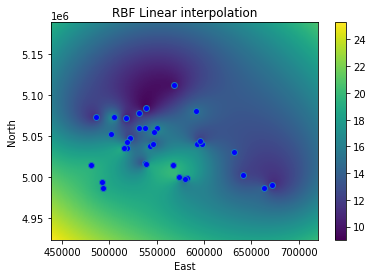

co_gdf


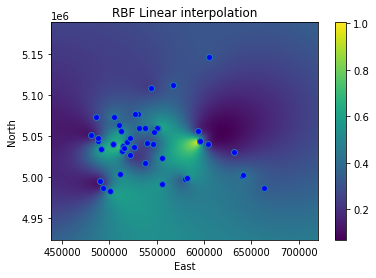

no2_gdf


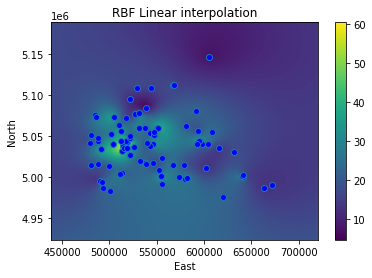

so2_gdf


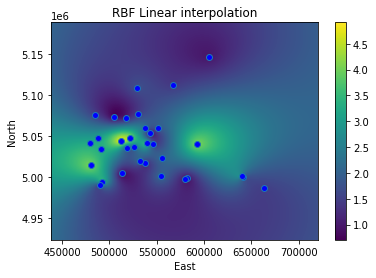

nh3_gdf


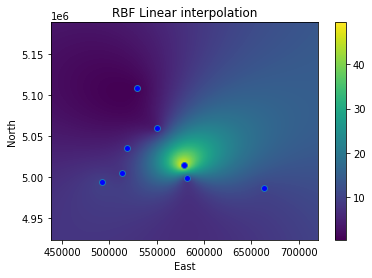

nox_gdf


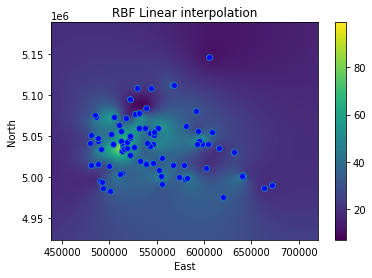

pm10_gdf


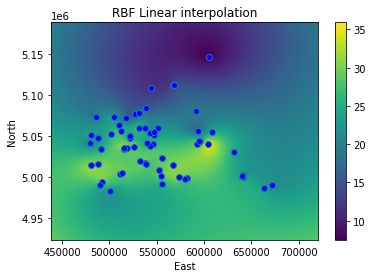

o3_gdf


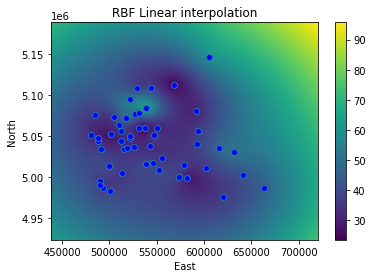

In [52]:
for key in aq_dict:
    east = aq_dict[key].geometry.x
    north = aq_dict[key].geometry.y
    value = aq_dict[key][['valore']]
    
    rbf = Rbf(east, north, value, function='linear')
    z_new = rbf(gridX.ravel(), gridY.ravel()).reshape(gridX.shape)
    print(key)
    plt.pcolor(gridX, gridY, z_new);
    plt.plot(east, north, 'o', markerfacecolor='blue');
    plt.xlabel('East'); plt.ylabel('North');
    plt.title('RBF Linear interpolation');
    plt.colorbar()
    plt.show()

    transform = Affine.translation(gridX[0][0]-rRes/2, gridY[0][0]-rRes/2)*Affine.scale(rRes,rRes)

    new_dataset = rio.open(cwd +'/temp/aq_rbf_'+key[:(len(key)-4)]+'.tif', 'w', driver='GTiff',
                            height = z_new.shape[0], width = z_new.shape[1],
                            count=1, dtype=str(z_new.dtype),
                            crs='+proj=utm +zone=32 +datum=WGS84 +units=m +no_defs',
                            transform=transform)

    new_dataset.write(z_new, 1)
    new_dataset.close()
    #Warp with GDAL since rasterio and rasterstats affine transformation don't work in the grid processing notebook
    ds = gdal.Warp(cwd +'/temp/int_'+key[:(len(key)-4)]+'.tif', cwd +'/temp/aq_rbf_'+key[:(len(key)-4)]+'.tif', dstSRS='EPSG:32632',
                   outputType=gdal.GDT_Float64, xRes=rRes, yRes=rRes)
    

temp_gdf


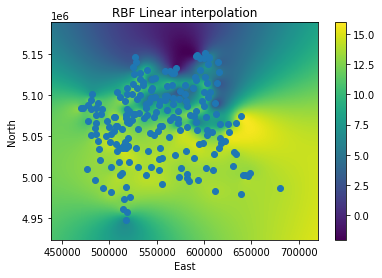

prec_gdf


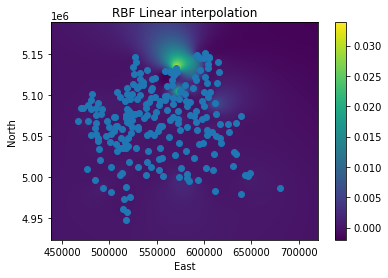

air_hum_gdf


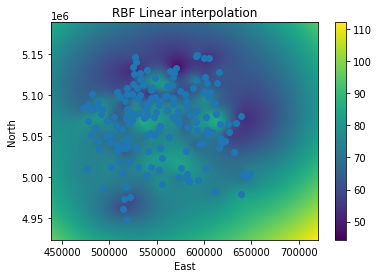

wind_speed_gdf


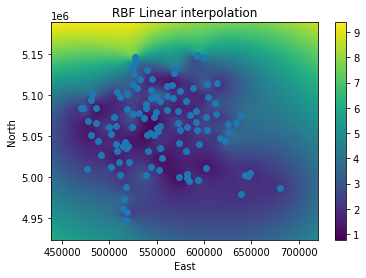

rad_glob_gdf


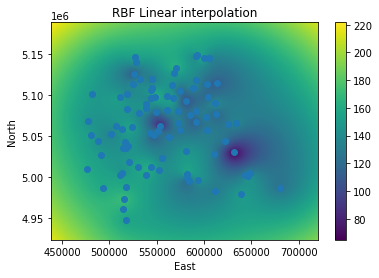

In [53]:
for key in meteo_dict:
    east = meteo_dict[key].geometry.x
    north = meteo_dict[key].geometry.y
    value = meteo_dict[key][['valore']]
    
    rbf = Rbf(east, north, value, function='linear')
    z_new = rbf(gridX.ravel(), gridY.ravel()).reshape(gridX.shape)
    print(key)
    plt.pcolor(gridX, gridY, z_new);
    plt.plot(east, north, 'o');
    plt.xlabel('East'); plt.ylabel('North');
    plt.title('RBF Linear interpolation');
    plt.colorbar()
    plt.show()

    transform = Affine.translation(gridX[0][0]-rRes/2, gridY[0][0]-rRes/2)*Affine.scale(rRes,rRes)

    new_dataset = rio.open(cwd +'/temp/meteo_rbf_'+key[:(len(key)-4)]+'.tif', 'w', driver='GTiff',
                            height = z_new.shape[0], width = z_new.shape[1],
                            count=1, dtype=str(z_new.dtype),
                            crs='+proj=utm +zone=32 +datum=WGS84 +units=m +no_defs',
                            transform=transform)

    new_dataset.write(z_new, 1)
    new_dataset.close()
    #Warp with GDAL since rasterio and rasterstats affine transformation don't work in the grid processing notebook
    ds = gdal.Warp(cwd +'/temp/int_'+key[:(len(key)-4)]+'.tif', cwd +'/temp/meteo_rbf_'+key[:(len(key)-4)]+'.tif', dstSRS='EPSG:32632',
                   outputType=gdal.GDT_Float64, xRes=rRes, yRes=rRes)

Statistics, Points Sampling with stations positions and rasters:

Data name : pm25_gdf
Max value from stations: 19.625
Max value from interpolated raster: 19.61316602194225
Min value from stations: 9.0
Min value from interpolated raster: 9.022349672115297
RMSE max: 0.3205865936850856
RMSE mean : 0.03957541103387395


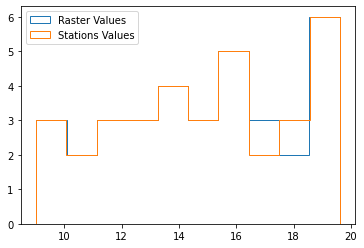

----------------------------------
Data name : co_gdf
Max value from stations: 1.007741935483871
Max value from interpolated raster: 1.004235790768309
Min value from stations: 0.10572916666666667
Min value from interpolated raster: 0.10821235995334266
RMSE max: 0.014541353921068811
RMSE mean : 0.00209619295778142


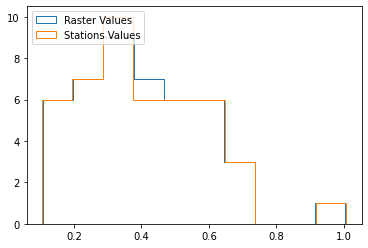

----------------------------------
Data name : no2_gdf
Max value from stations: 60.58247422680412
Max value from interpolated raster: 60.35545399168245
Min value from stations: 4.7046874999999995
Min value from interpolated raster: 4.856886163723971
RMSE max: 1.4060534433971767
RMSE mean : 0.1743158983924208


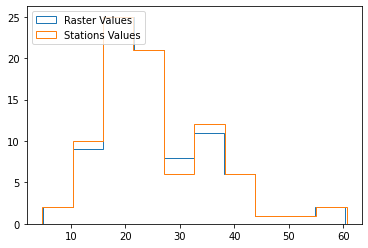

----------------------------------
Data name : so2_gdf
Max value from stations: 4.91578947368421
Max value from interpolated raster: 4.913052168672319
Min value from stations: 0.6895833333333333
Min value from interpolated raster: 0.7045633407601972
RMSE max: 0.05813203083069429
RMSE mean : 0.008245322747666374


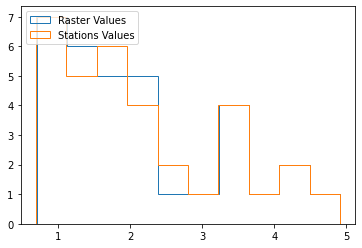

----------------------------------
Data name : nh3_gdf
Max value from stations: 49.5375
Max value from interpolated raster: 49.47808657631958
Min value from stations: 0.5428571428571428
Min value from interpolated raster: 0.5416806610557288
RMSE max: 0.05941342368041802
RMSE mean : 0.018435370989416625


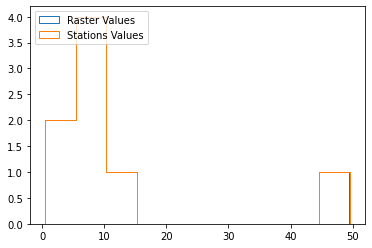

----------------------------------
Data name : nox_gdf
Max value from stations: 99.61875
Max value from interpolated raster: 99.17461893267773
Min value from stations: 6.8078125
Min value from interpolated raster: 7.064832984295265
RMSE max: 2.755483567321164
RMSE mean : 0.33319125780702363


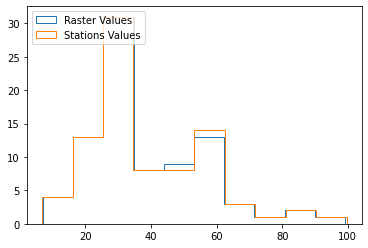

----------------------------------
Data name : pm10_gdf
Max value from stations: 36.0
Max value from interpolated raster: 35.87818812294776
Min value from stations: 7.5
Min value from interpolated raster: 7.508899989133056
RMSE max: 0.9334161273457191
RMSE mean : 0.07919263926341974


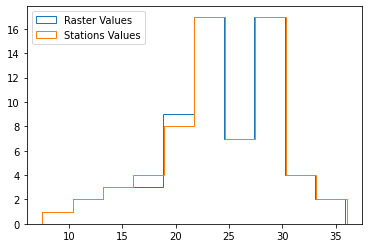

----------------------------------
Data name : o3_gdf
Max value from stations: 69.9109375
Max value from interpolated raster: 69.69320296400225
Min value from stations: 23.450595238095236
Min value from interpolated raster: 23.530892686233983
RMSE max: 0.2177345359977494
RMSE mean : 0.052313179661839605


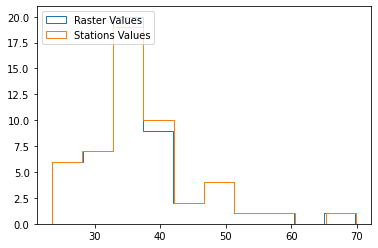

----------------------------------


In [54]:
for key in aq_dict:
    raster = rio.open(cwd +'/temp/int_'+key[:(len(key)-4)]+'.tif')
    east = aq_dict[key].geometry.x
    north = aq_dict[key].geometry.y
    value = aq_dict[key][['valore']]
    aq_dict[key].index = range(len(aq_dict[key]))
    coords = [(x,y) for x, y in zip(aq_dict[key].geometry.x,aq_dict[key].geometry.y)]
    aq_dict[key]['Raster Value'] = [x[0] for x in raster.sample(coords)]
    rmse = ((aq_dict[key]['Raster Value'] - aq_dict[key]['valore'])**2)**(1/2)
    print("Data name : {name}".format(name = key))
    print("Max value from stations: {value}".format(value = aq_dict[key]['valore'].max()))
    print("Max value from interpolated raster: {value}".format(value=aq_dict[key]['Raster Value'].max()))
    print("Min value from stations: {value}".format(value = aq_dict[key]['valore'].min()))
    print("Min value from interpolated raster: {value}".format(value=aq_dict[key]['Raster Value'].min()))
    print("RMSE max: {rmse}".format(rmse = rmse.max()))
    print("RMSE mean : {rmse}".format(rmse = rmse.mean()))
    plt.hist(aq_dict[key]['Raster Value'], label = 'Raster Values', histtype='step')
    plt.hist(aq_dict[key]['valore'], label = 'Stations Values', histtype='step')
    plt.legend(loc="upper left")
    plt.show()
    print("----------------------------------")
    

Data name : temp_gdf
Max value from stations: 15.982378472222223
Max value from interpolated raster: 15.960390215965091
Min value from stations: -2.0024305555555557
Min value from interpolated raster: -1.9083935651120498
RMSE max: 0.15778983385215817
RMSE mean : 0.02936273409194757


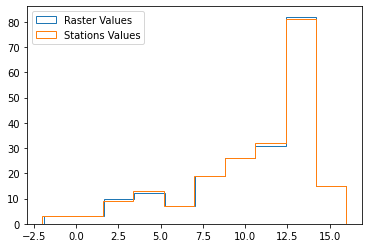

----------------------------------
Data name : prec_gdf
Max value from stations: 0.03402777777777778
Max value from interpolated raster: 0.03312699392904499
Min value from stations: 0.0
Min value from interpolated raster: -6.1775812251183e-05
RMSE max: 0.0009007838487327946
RMSE mean : 1.6901091926967435e-05


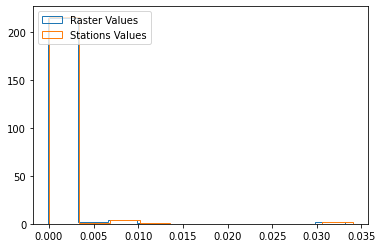

----------------------------------
Data name : air_hum_gdf
Max value from stations: 90.76229365768897
Max value from interpolated raster: 90.62415574470452
Min value from stations: 44.22569444444444
Min value from interpolated raster: 44.489627727015204
RMSE max: 1.0409071419942748
RMSE mean : 0.09946424724445128


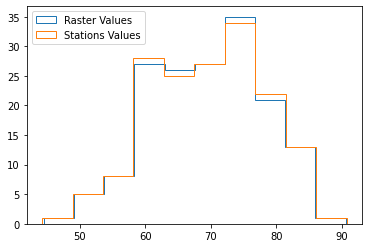

----------------------------------
Data name : wind_speed_gdf
Max value from stations: 7.380959752321982
Max value from interpolated raster: 7.34081137791792
Min value from stations: 0.7640625
Min value from interpolated raster: 0.7724709240412722
RMSE max: 0.0716889674581358
RMSE mean : 0.009714920812813886


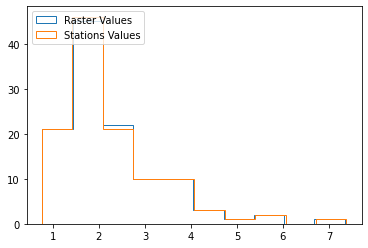

----------------------------------
Data name : rad_glob_gdf
Max value from stations: 172.28385416666666
Max value from interpolated raster: 172.2292310093393
Min value from stations: 64.68802083333334
Min value from interpolated raster: 64.88494850664392
RMSE max: 0.9421955992454514
RMSE mean : 0.14039744773599824


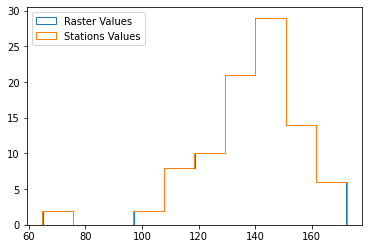

----------------------------------


In [55]:
for key in meteo_dict:
    raster = rio.open(cwd +'/temp/int_'+key[:(len(key)-4)]+'.tif')
    east = meteo_dict[key].geometry.x
    north = meteo_dict[key].geometry.y
    value = meteo_dict[key][['valore']]
    meteo_dict[key].index = range(len(meteo_dict[key]))
    coords = [(x,y) for x, y in zip(meteo_dict[key].geometry.x, meteo_dict[key].geometry.y)]
    meteo_dict[key]['Raster Value'] = [x[0] for x in raster.sample(coords)]
    rmse = ((meteo_dict[key]['Raster Value'] - meteo_dict[key]['valore'])**2)**(1/2)
    print("Data name : {name}".format(name = key))
    print("Max value from stations: {value}".format(value = meteo_dict[key]['valore'].max()))
    print("Max value from interpolated raster: {value}".format(value=meteo_dict[key]['Raster Value'].max()))
    print("Min value from stations: {value}".format(value = meteo_dict[key]['valore'].min()))
    print("Min value from interpolated raster: {value}".format(value=meteo_dict[key]['Raster Value'].min()))
    print("RMSE max: {rmse}".format(rmse = rmse.max()))
    print("RMSE mean : {rmse}".format(rmse = rmse.mean()))
    plt.hist(meteo_dict[key]['Raster Value'], label = 'Raster Values', histtype='step')
    plt.hist(meteo_dict[key]['valore'], label = 'Stations Values', histtype='step')
    plt.legend(loc="upper left")
    plt.show()
    print("----------------------------------")
        

# ESA LPS Air Quality Platform data request notebook

This notebook is used to download data from both meteorological and air quality ground sensor of LPS Air Quality Platform data.

The data are retrieved using the API service.
The sensors available are: 
- PM2.5
- PM10
- NO2
- CO2
- NH3
- CO
- Temperature
- Humidity

The API request downloads the data in the given time range. A Z-Score test is performed to remove outliers and the mean value for each sensor is calculated.
Mean values for each sensor are saved in geopackage format.

### Reference website: 
- ESA LPS Air Quality Platform: https://aqp.eo.esa.int/aqstation/
- ESA LPS Air Quality Platform sensor map: https://aqp.eo.esa.int/map/

In [56]:
device_list = [1, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 36, 58]  #list of devices considered to make the request 

In [57]:
aq_data = []

In [58]:
for i in range(len(device_list)):
    url = 'https://api.aqp.eo.esa.int/api/device/'+str(device_list[i])+'/csv?start_date='+start_date+'&end_date='+end_date
    urlData = requests.get(url).content
    rawData = pd.read_csv(io.StringIO(urlData.decode('utf-8')))
    aq_data.append(rawData)

df_data = pd.concat((pd.DataFrame(data) for data in aq_data), ignore_index=True)

In [59]:
list_active = list(df_data.device_id.unique())
list_active

[11, 16, 36]

In [60]:
aq_data = []
del df_data

In [61]:
for i in range(len(list_active)):
    url = 'https://api.aqp.eo.esa.int/api/device/'+str(list_active[i])+'/csv?start_date='+start_date+'&end_date='+end_date
    urlData = requests.get(url).content
    rawData = pd.read_csv(io.StringIO(urlData.decode('utf-8')))
    aq_data.append(rawData)

df_data = pd.concat((pd.DataFrame(data) for data in aq_data), ignore_index=True)

In [62]:
sel_columns = ['device_id', 'acquisition_date','latitude', 
           'longitude', 'pm25', 'pm10', 'humidity', 'temperature',
          'no2', 'co2', 'nh3', 'co']

In [63]:
df = df_data[sel_columns]

In [64]:
df

device_id     acquisition_date   latitude  longitude  pm25  pm10  \
0             11  2021-10-08 11:18:37  45.497683   9.241159   4.7  22.2   
1             11  2021-10-08 11:19:46  45.497683   9.241159   4.8  22.4   
2             11  2021-10-08 11:20:51  45.497683   9.241159   4.3  18.5   
3             11  2021-10-08 11:21:56  45.497683   9.241159   4.6  21.2   
4             11  2021-10-08 11:23:01  45.497683   9.241159   4.3  19.1   
...          ...                  ...        ...        ...   ...   ...   
33493         36  2021-10-15 23:54:48  45.534771  10.231425   1.5   1.6   
33494         36  2021-10-15 23:55:52  45.534771  10.231425   1.4   1.9   
33495         36  2021-10-15 23:56:59  45.534771  10.231425   1.6   2.6   
33496         36  2021-10-15 23:58:04  45.534771  10.231425   1.5   2.1   
33497         36  2021-10-15 23:59:08  45.534771  10.231425   1.5   1.6   

       humidity  temperature   no2     co2   nh3    co  
0          62.7         21.9  0.86  400.00  0.28  4.81  
1          62.5         21.9  0.82  375.63  0.14  4.63  
2          62.5         21.9  0.83  375.63  0.08  4.60  
3          62.1         22.1  0.87  364.00  0.06  4.56  
4          61.6         22.3  0.93  352.74  0.04  4.56  
...         ...          ...   ...     ...   ...   ...  
33493      20.6         23.2  0.15   28.53  0.64  5.16  
33494      20.5         23.2  0.15   28.53  0.64  5.16  
33495      20.4         23.2  0.15   29.44  0.63  5.12  
33496      20.4         23.3  0.15   30.38  0.63  5.12  
33497      20.5         23.2  0.15   31.35  0.64  5.12  

[33498 rows x 12 columns]

In [65]:
df['acquisition_date'] = pd.to_datetime(df['acquisition_date'], format='%Y-%m-%d %H:%M:%S')

In [66]:
pm25 = df[['device_id','acquisition_date', 'latitude', 'longitude', 'pm25']]
pm10 = df[['device_id','acquisition_date', 'latitude', 'longitude', 'pm10']]
humidity = df[['device_id','acquisition_date', 'latitude', 'longitude', 'humidity']]
temperature = df[['device_id','acquisition_date', 'latitude', 'longitude', 'temperature']]
no2 = df[['device_id','acquisition_date', 'latitude', 'longitude', 'no2']]
co2 = df[['device_id','acquisition_date', 'latitude', 'longitude', 'co2']]
nh3 = df[['device_id','acquisition_date', 'latitude', 'longitude', 'nh3']]
co = df[['device_id','acquisition_date', 'latitude', 'longitude', 'co']]

In [67]:
pm25 = pm25.rename(columns={'pm25': 'value'})
pm10 = pm10.rename(columns={'pm10': 'value'})
humidity = humidity.rename(columns={'humidity': 'value'})
temperature = temperature.rename(columns={'temperature': 'value'})
no2 = no2.rename(columns={'no2': 'value'})
co2 = co2.rename(columns={'co2': 'value'})
nh3 = nh3.rename(columns={'nh3': 'value'})
co = co.rename(columns={'co': 'value'})

In [68]:
pm25['zscore'] = np.abs(stats.zscore(pm25['value'], nan_policy='omit'))
pm25 = pm25[pm25.zscore < threshold]
pm25 = pm25.groupby(['device_id'],as_index=False).mean()

In [69]:
pm10['zscore'] = np.abs(stats.zscore(pm10['value'], nan_policy='omit'))
pm10 = pm10[pm10.zscore < threshold]
pm10 = pm10.groupby(['device_id'],as_index=False).mean()

In [70]:
humidity['zscore'] = np.abs(stats.zscore(humidity['value'], nan_policy='omit'))
humidity = humidity[humidity.zscore < threshold]
humidity = humidity.groupby(['device_id'],as_index=False).mean()

In [71]:
temperature['zscore'] = np.abs(stats.zscore(temperature['value'], nan_policy='omit'))
temperature = temperature[temperature.zscore < threshold]
temperature = temperature.groupby(['device_id'],as_index=False).mean()

In [72]:
no2['zscore'] = np.abs(stats.zscore(no2['value'], nan_policy='omit'))
no2 = no2[no2.zscore < threshold]
no2 = no2.groupby(['device_id'],as_index=False).mean()

In [73]:
co2['zscore'] = np.abs(stats.zscore(co2['value'], nan_policy='omit'))
co2 = co2[co2.zscore < threshold]
co2 = co2.groupby(['device_id'],as_index=False).mean()

In [74]:
nh3['zscore'] = np.abs(stats.zscore(nh3['value'], nan_policy='omit'))
nh3 = nh3[nh3.zscore < threshold]
nh3 = nh3.groupby(['device_id'],as_index=False).mean()

In [75]:
co['zscore'] = np.abs(stats.zscore(co['value'], nan_policy='omit'))
co = co[co.zscore < threshold]
co = co.groupby(['device_id'],as_index=False).mean()

Create Geodataframe and save in geopackage:

In [76]:
pm25_gdf = gpd.GeoDataFrame(pm25, geometry=gpd.points_from_xy(pm25.longitude, pm25.latitude)).set_crs('epsg:4326')
pm10_gdf = gpd.GeoDataFrame(pm10, geometry=gpd.points_from_xy(pm10.longitude, pm10.latitude)).set_crs('epsg:4326')
hum_gdf = gpd.GeoDataFrame(humidity, geometry=gpd.points_from_xy(humidity.longitude, humidity.latitude)).set_crs('epsg:4326')
temp_gdf = gpd.GeoDataFrame(temperature, geometry=gpd.points_from_xy(temperature.longitude, temperature.latitude)).set_crs('epsg:4326')
no2_gdf = gpd.GeoDataFrame(no2, geometry=gpd.points_from_xy(no2.longitude, no2.latitude)).set_crs('epsg:4326')
co2_gdf = gpd.GeoDataFrame(co2, geometry=gpd.points_from_xy(co2.longitude, co2.latitude)).set_crs('epsg:4326')
nh3_gdf = gpd.GeoDataFrame(nh3, geometry=gpd.points_from_xy(nh3.longitude, nh3.latitude)).set_crs('epsg:4326')
co_gdf = gpd.GeoDataFrame(co, geometry=gpd.points_from_xy(co.longitude, co.latitude)).set_crs('epsg:4326')

In [77]:
pm25_gdf.to_file(cwd+"/temp/pm25_lcs.gpkg", driver="GPKG")
pm10_gdf.to_file(cwd+"/temp/pm10_lcs.gpkg", driver="GPKG")
hum_gdf.to_file(cwd+"/temp/hum_lcs.gpkg", driver="GPKG")
temp_gdf.to_file(cwd+"/temp/temp_lcs.gpkg", driver="GPKG")
no2_gdf.to_file(cwd+"/temp/no2_lcs.gpkg", driver="GPKG")
co2_gdf.to_file(cwd+"/temp/co2_lcs.gpkg", driver="GPKG")
nh3_gdf.to_file(cwd+"/temp/nh3_lcs.gpkg", driver="GPKG")
co_gdf.to_file(cwd+"/temp/co_lcs.gpkg", driver="GPKG")

In [78]:
pm10_gdf

device_id   latitude  longitude      value    zscore  \
0         11  45.497771   9.241014  15.083140  0.341164   
1         16  45.477748   9.227293   0.454979  0.297227   
2         36  45.534771  10.231425   4.062430  0.180949   

                    geometry  
0   POINT (9.24101 45.49777)  
1   POINT (9.22729 45.47775)  
2  POINT (10.23142 45.53477)

In [79]:
bnd = gpd.read_file('C:/Users/Administrator/OneDrive - Politecnico di Milano/WP2/D-DUST/boundaries/lombardy_region2020.gpkg').to_crs('epsg:4326')

<AxesSubplot:>

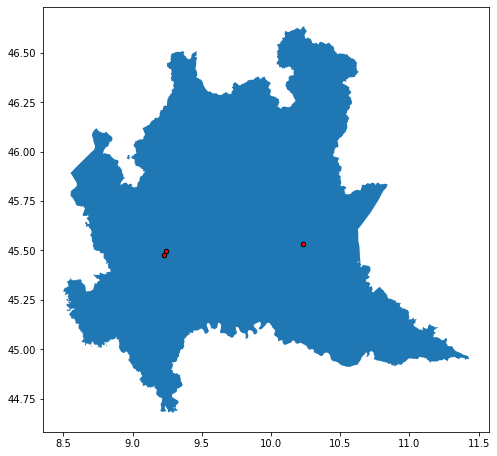

In [80]:
fig, ax = plt.subplots(figsize=(8, 8))
bnd.plot(ax = ax);
hum_gdf.plot(ax=ax,marker='o', color='red', markersize=20, edgecolors='black')

----

In [81]:
# from pykrige.ok import OrdinaryKriging
# from pykrige.kriging_tools import write_asc_grid
# import pykrige.kriging_tools as kt

In [82]:
# for key in aq_dict:
#     east = aq_dict[key].geometry.x
#     north = aq_dict[key].geometry.y
#     value = aq_dict[key][['valore']]
#     n_sensor = aq_dict[key].shape[0]  #VERIFICARE nlags in funzione del numero di sensori (defaul 6)
#     lag = int(math.sqrt(n_sensor))
    
#     OK = OrdinaryKriging(east, north,value, weight=True,nlags= lag ,variogram_model='power',coordinates_type='euclidean') #verbose=True, enable_plotting=False, weight=w
#     # print(UniversalKriging.__doc__ )
#     gridded, ss1 = OK.execute('grid', xRange, yRange)
#     transform = Affine.translation(gridX[0][0]-rRes/2, gridY[0][0]-rRes/2)*Affine.scale(rRes,rRes)
#     rasterCrs = CRS.from_epsg(32632)
#     #definition, register and close of interpolated raster
#     interpRaster = rio.open(cwd +'/temp/aq_krig_'+key[:(len(key)-4)]+'.tif',
#                                     'w',
#                                     driver='GTiff',
#                                     height=gridded.shape[0],
#                                     width=gridded.shape[1],
#                                     count=1,
#                                     nodata = -9999,
#                                     dtype=gridded.dtype,
#                                     crs=rasterCrs,
#                                     transform=transform,
#                                     )
#     interpRaster.write(gridded, 1)
#     interpRaster.close()
#     #Warp with GDAL since rasterio and rasterstats affine transformation don't work in the grid processing notebook
#     ds = gdal.Warp(cwd +'/temp/int_'+key[:(len(key)-4)]+'.tif', cwd +'/temp/aq_krig_'+key[:(len(key)-4)]+'.tif', dstSRS='EPSG:32632',
#                outputType=gdal.GDT_Float64, xRes=rRes, yRes=rRes)
#     print(key)
#     plt.imshow(gridded)
#     plt.show()

In [83]:
# for key in meteo_dict:
#     east = meteo_dict[key].geometry.x
#     north = meteo_dict[key].geometry.y
#     value = meteo_dict[key][['valore']]
#     n_sensor = meteo_dict[key].shape[0]  #VERIFICARE nlags in funzione del numero di sensori (defaul 6)
#     lag = int(math.sqrt(n_sensor))
    
#     OK = OrdinaryKriging(east, north, value, nlags= lag,
#                  weight=True, variogram_model='power',coordinates_type='euclidean') #verbose=True, enable_plotting=False, weight=w
#     # print(OrdinaryKriging.__doc__)
#     gridded, ss1 = OK.execute('grid', xRange, yRange)
#     transform = Affine.translation(gridX[0][0]-rRes/2, gridY[0][0]-rRes/2)*Affine.scale(rRes,rRes)
#     rasterCrs = CRS.from_epsg(32632)
#     #definition, register and close of interpolated raster
#     interpRaster = rio.open(cwd +'/temp/meteo_krig_'+key[:(len(key)-4)]+'.tif',
#                                     'w',
#                                     driver='GTiff',
#                                     height= gridded.shape[0],
#                                     width= gridded.shape[1],
#                                     count=1,
#                                     nodata = -9999,
#                                     dtype=gridded.dtype,
#                                     crs=rasterCrs,
#                                     transform=transform,
#                                     )
#     interpRaster.write(gridded, 1)
#     interpRaster.close()
#     #Warp with GDAL since rasterio and rasterstats affine transformation don't work in the grid processing notebook
#     ds = gdal.Warp(cwd +'/temp/int_'+key[:(len(key)-4)]+'.tif', cwd +'/temp/meteo_krig_'+key[:(len(key)-4)]+'.tif', dstSRS='EPSG:32632',
#                outputType=gdal.GDT_Float64, xRes=rRes, yRes=rRes)
#     print(key)
#     print(lag)
#     plt.imshow(gridded)
#     plt.show()

Notes:

In [84]:
# INTERPOLATION USING GDAL
# pts = ogr.Open(cwd+'/temp/air_hum_st.gpkg', update = True)
# layer=pts.GetLayer()

# to generate a an interpolation using GDAL library
# pts = layer = None
# idw = gdal.Grid("idw.tif", (cwd+'/temp/air_hum_st.gpkg'), zfield="valore",
#                algorithm = "invdist", outputBounds = [ulx,uly,lrx,lry],
#                width = xsize, height = ysize)
# idw = None

# points = list(zip(air_hum_st.lng,air_hum_st.lat))

# gridded = griddata(points, value, (gridX,gridY), method='linear',fill_value=0)

# gridded = gridded.reshape((gridded.shape[0], gridded.shape[1]))

# plt.imshow(gridded)

In [85]:
#Mask data using date range
#mask = (meteo_data['data'] >= start_date) & (meteo_data['data'] < end_date)
#meteo_data = meteo_data.loc[mask]
#meteo_data

In [86]:
# print(list(arpa_df.columns))
# print(arpa_df['idsensore'].values)

In [87]:
# results = client.get_all(dati, idsensore = "100", data='2022-01-20')
# results

In [88]:
# arpa_df.loc[arpa_df['idsensore'] == "10377"]